In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from joblib import dump,load
from sklearn import metrics

In [2]:
def read_csv(name,sep=","):
    data = pd.read_csv(name,sep=sep)
    return data

def read_from_file(typ_,name,sep=None):
    if typ_ == "csv":
        data = read_csv(name,sep)
    else:
        data = None
    return data

def read_from_data(typ_,data):
    return None

def read_from_file_or_data(typ_,sect=None,name=None,data=None,sep=None):
    if sect == "file":
        data = read_from_file(typ_,name,sep)
    else:
        data = read_from_data(typ_,data)
    return data

In [3]:
def write_dataframe_csv(dataframe,name):
    dataframe.to_csv(name)

def write_data(typ_,data,name):
    if typ_ == "csv":
        write_dataframe_csv(data,name)
    else:
        pass

In [4]:
def load_one(data):
    return data

def load_two(data1,data2,axis=0,drop_index=True):
    combined = pd.concat([data1,data2],axis=axis)
    combined = combined.sample(frac=1,random_state=2).reset_index(drop=drop_index)
    return combined

def loader(typ_,data,axis=0,drop_index=True):
    if typ_ == "one":
        data = load_one(data)
    elif typ_ == "two":
        data = load_two(data[0],data[1],axis=0,drop_index=True)
    else:
        data = None
    return data



In [5]:
def data_spliter(train,label,random_state=2,test_size=0.3):
    train_x,test_x,train_y,test_y = train_test_split(train,label,random_state=random_state,test_size=test_size)
    return train_x,test_x,train_y,test_y

def set_ss(data):
    ss = StandardScaler()
    scaled = ss.fit_transform(data)
    return scaled

def scalers(typ_,data):
    scaled = None
    if typ_ == "ss":
        scaled = set_ss(data)
    else:
        pass
    return scaled


def select_train_columns(data,n):
    train = data.iloc[:,:n]
    return train,train.columns

def select_label_column(data,column_name):
    labels = np.array(data[column_name])
    return labels

In [6]:
def dcl_train(train,label,model_name):
    dcl = DecisionTreeClassifier()
    dcl.fit(train,label)
    dump(dcl,model_name)
    return dcl

def train(typ_,train,label,model_name):
    if typ_ == "dcl":
        return dcl_train(train,label,model_name)
    else:
        return None


In [7]:
def predict(model_name,data):
    model = load(model_name)
    label = model.predict(data)
    return label

In [9]:
def retrain_with_new_data(model_name,train,label):
    model = load(model_name)
    model.fit(train,label)
    dump(model,model_name)
    return model


def retrain_with_new_and_old_data(model_name,train,label):
    c_train = np.vstack([train[0], train[1]])
    clabel = np.concatenate([label[0], label[1]])
    model = load(model_name)
    model.fit(c_train,clabel)
    dump(model,model_name)
    return model

def retrain(typ_,model_name,train,label):
    if typ_ == "only_new":
        model = retrain_with_new_data(model_name,train,label)
    elif typ_ == "new_and_old":
        model = retrain_with_new_and_old_data(model_name,train,label)
    else:
        pass
    return model

In [10]:
def get_metrics(true_labels, predicted_labels):
    metrics_ = {}

    metrics_['Accuracy:'] = np.round(metrics.accuracy_score(true_labels,predicted_labels),4)
    metrics_['Precision:'] =  np.round(metrics.precision_score(true_labels,predicted_labels,average='weighted'),4)
    metrics_['Recall:'] = np.round(metrics.recall_score(true_labels,predicted_labels,average='weighted'),4)
    metrics_['F1 Score:'] = np.round(metrics.f1_score(true_labels,predicted_labels,average='weighted'),4)
    return metrics_

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels,
                                           y_pred=predicted_labels,
                                           labels=classes)
    return report



def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    stats = {}
    metrics = get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    report = display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels,classes=classes)
    stats["metrics"] = metrics
    print("report: ",report)
    stats["report"] = report
    return stats

def model_analysis(true_labels,predicted_labels,classes,typ_="default"):
    if typ_ == "default":
        metrics = display_model_performance_metrics(true_labels, predicted_labels,classes)
    else:
        pass
    return metrics


In [11]:
def label_encoder(data):
    l = LabelEncoder()
    data = l.fit_transform(data)
    return data

In [12]:
def covert_objects_to_int(data):
    columns = data.columns
    for i in columns:
        if data[i].dtype == object:
            data[i] = label_encoder(data[i])
    return data



In [29]:
#model
def model(loader_type,data,data_type,scaler_type,model_type,model_name,analysis_type,train_column_limit,classes,label,test_ratio=0.3):
    data = loader(loader_type,data,axis=0,drop_index=True)

    #convert objects to int
    rta_ = covert_objects_to_int(data)

    #column and label selection
    rta_t,columns = select_train_columns(data,train_column_limit)
    rta_label = select_label_column(data,label)

    #spilting
    rta_t_train_x1,rta_t_test_x1,rta_label_train_y1,rta_label_test_y1 = data_spliter(rta_t,rta_label,random_state=2,test_size=test_ratio)

    #saving training and testing data
    write_data(data_type,rta_t_train_x1,"training")
    write_data(data_type,rta_t_test_x1,"testing")

    #scaling
    ss1_fit = scalers(scaler_type,rta_t_train_x1)
    ss1_test = scalers(scaler_type,rta_t_test_x1)


    #training of the model
    model = train(model_type,rta_t_train_x1,rta_label_train_y1,model_name)

    #predicting
    preds = predict(model_name,ss1_test)

    #evaluation
    metrics = model_analysis(rta_label_test_y1,preds,classes,typ_=analysis_type)
    return metrics


In [14]:
#prediction
def prediction(data,model_name,scaler_type):
    data = pd.DataFrame(data,index=[0])
    data = covert_objects_to_int(data)
    data = scalers(scaler_type,data)
    preds = predict(model_name,data)
    return preds

In [27]:
#retraining
def retrained(train,label,test,test_label,classes,typ_,model_name,scaler_type,analysis_type):
    model = retrain(typ_=typ_,model_name=model_name,train=train,label=label)
    preds = model.predict(test)
    #evaluation
    metrics = model_analysis(true_labels=test_label,predicted_labels=preds,classes=classes,typ_=analysis_type)
    return metrics

def process(loader_type,train,label,train_column_limit,data_type,scaler_type,test_ratio=0.3):
    train = loader(loader_type,train,axis=0,drop_index=True)

    #convert objects to int
    train = covert_objects_to_int(train)

    #column and label selection
    label = select_label_column(train,label)
    train,columns = select_train_columns(train,train_column_limit)


    #spilting
    train_x,test_x,label_x,test_y = data_spliter(train,label,random_state=2,test_size=test_ratio)

    #saving training and testing data
    write_data(data_type,train_x,"training")
    write_data(data_type,test_x,"test")

    #scaling
    scaled_train_x = scalers(scaler_type,train_x)
    scaled_test_x = scalers(scaler_type,test_x)
    return scaled_train_x,scaled_test_x,label_x,test_y

In [17]:
data = "/content/cleaned.csv"
rta = read_from_file_or_data(sect="file",typ_="csv",name=data,sep=",")

rta.head()

,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident,Accident_severity
0,18-30,Male,Above high school,Employee,1-2yr,Unknown,No junction,Asphalt roads,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,Not a Pedestrian,Moving Backward,2
1,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2
2,18-30,Male,Junior high school,Employee,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with roadside objects,Going straight,Not a Pedestrian,Changing lane to the left,1
3,18-30,Male,Junior high school,Employee,5-10yr,other,Y Shape,Earth roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Changing lane to the right,2
4,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2


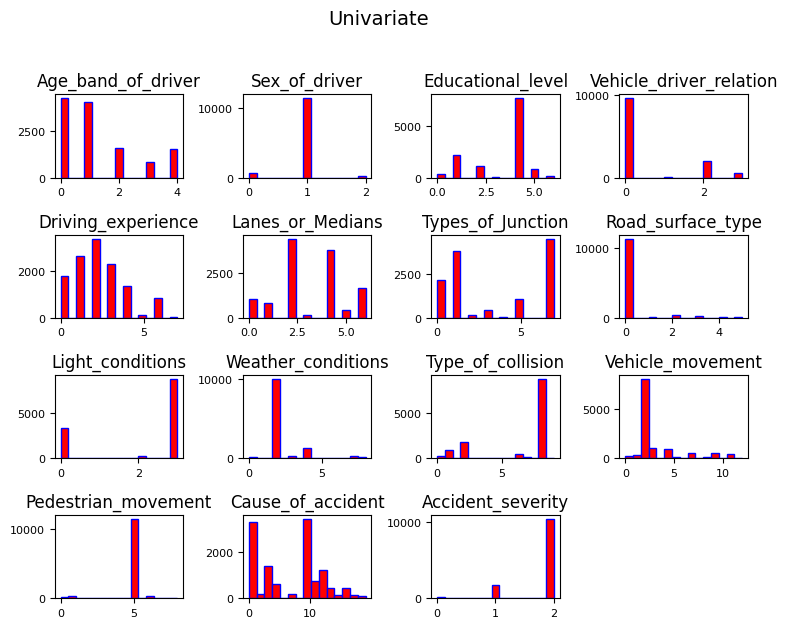

In [22]:
rta_ = covert_objects_to_int(rta)
#Univariate Analysis
rta_.hist(bins=15,edgecolor="blue",color="red",linewidth=1.0,xlabelsize=8,ylabelsize=8,grid=False)
plt.tight_layout(rect=(0.0,0.0,1.2,1.2))
plt.suptitle("Univariate",x=0.6,y=1.3,fontsize=14)
plt.show()

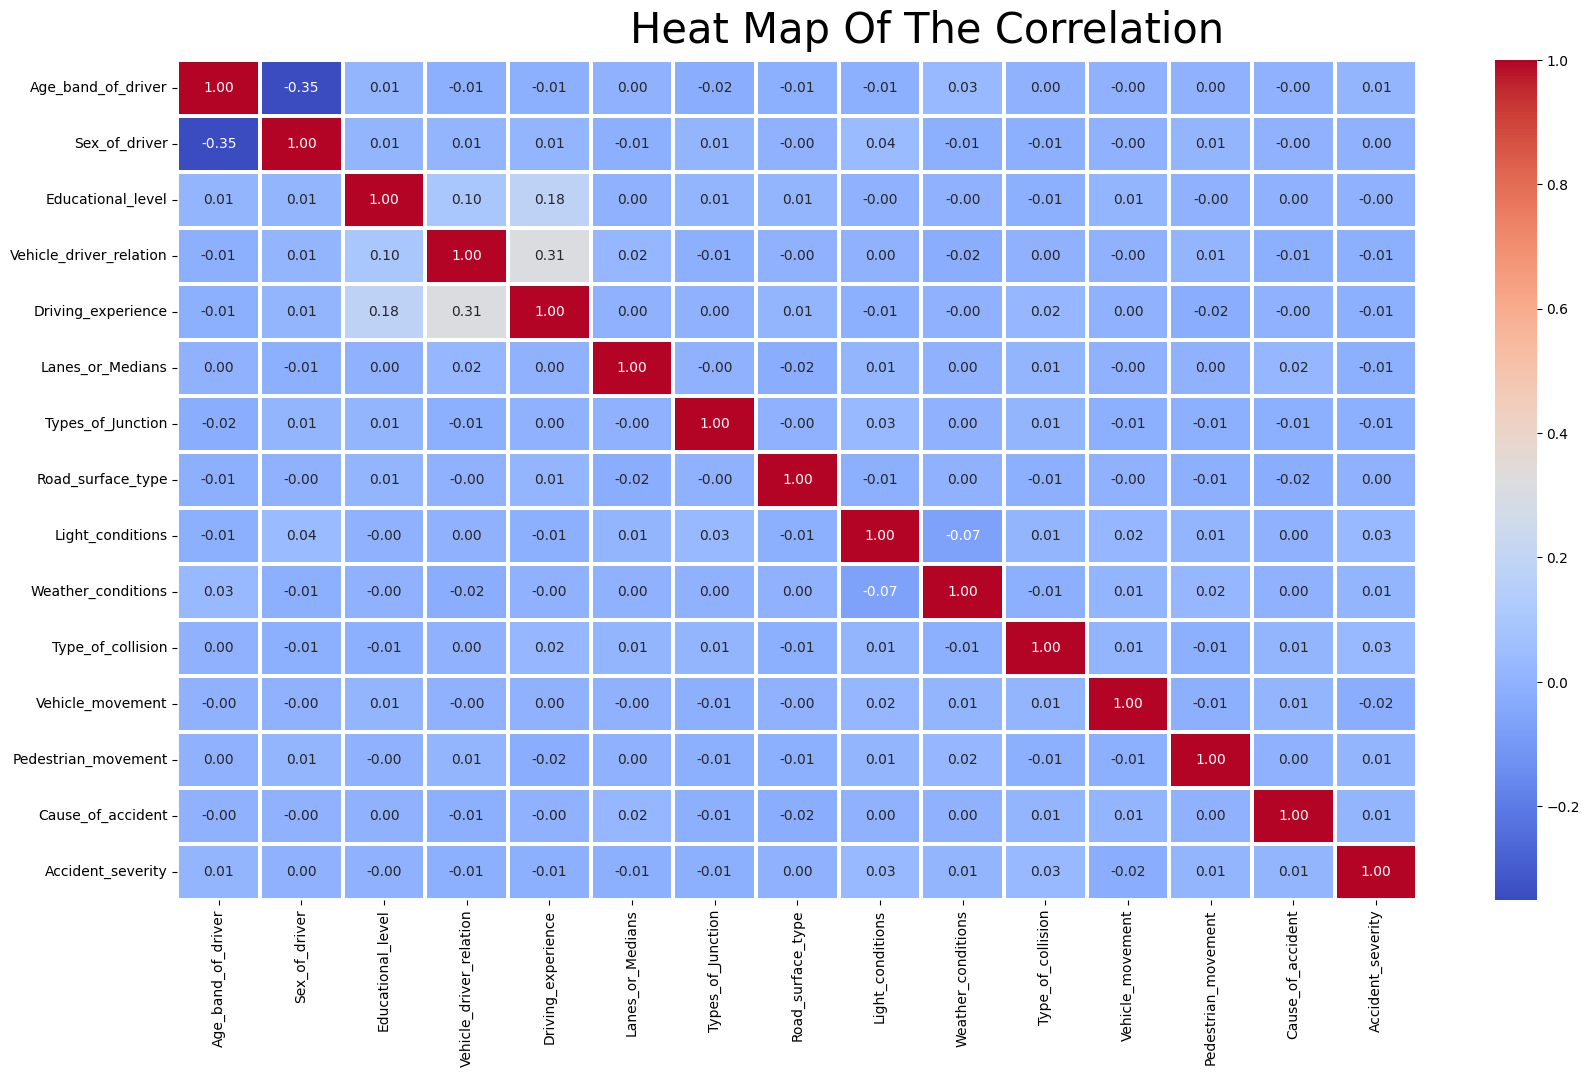

In [23]:
#MulitVariate Analyis
fig,ax = plt.subplots(figsize=(20,10))
rta_corr = rta_.corr()
heatmap = sns.heatmap(round(rta_corr,2),ax=ax,annot=True,cmap="coolwarm",fmt=".2f",linewidths=1.5)
fig.subplots_adjust(top=0.95)
t = fig.suptitle("Heat Map Of The Correlation",y=1,fontsize=30)

In [30]:
model(loader_type="one",data=rta,data_type="csv",scaler_type="ss",model_type="dcl",model_name="dck",analysis_type="default",train_column_limit=-1,classes=[0,1,2],label="Accident_severity",test_ratio=0.3)

report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.17      0.33      0.22       544
           2       0.85      0.72      0.78      3101

    accuracy                           0.65      3695
   macro avg       0.34      0.35      0.33      3695
weighted avg       0.74      0.65      0.69      3695



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


{'metrics': {'Accuracy:': np.float64(0.6528),
  'Precision:': np.float64(0.7377),
  'Recall:': np.float64(0.6528),
  'F1 Score:': np.float64(0.6869)},
 'report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        50\n           1       0.17      0.33      0.22       544\n           2       0.85      0.72      0.78      3101\n\n    accuracy                           0.65      3695\n   macro avg       0.34      0.35      0.33      3695\nweighted avg       0.74      0.65      0.69      3695\n'}

In [32]:
g = {"Age_band_of_driver":0,
"Sex_of_driver":1,
"Educational_level":0,
"Vehicle_driver_relation":0,
"Driving_experience":0,
"Lanes_or_Medians":5,
"Types_of_Junction":1,
"Road_surface_type":0,
"Light_conditions":3,
"Weather_conditions":2,
"Type_of_collision":3,
"Vehicle_movement":2,
"Pedestrian_movement":5,
"Cause_of_accident":9}

prediction(data=g,model_name="/content/dck",scaler_type="ss")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([2])

In [33]:
train_x,test_x,label_x,test_y = process(loader_type="one",train=rta,label="Accident_severity",train_column_limit=-1,scaler_type="ss",data_type="csv",test_ratio=0.3)

retrained(train=train_x,label=label_x,test=test_x,test_label=test_y,classes=[0,1,2],typ_="only_new",model_name="dck",scaler_type="ss",analysis_type="default")

report:                precision    recall  f1-score   support

           0       0.02      0.02      0.02        50
           1       0.16      0.19      0.17       544
           2       0.84      0.81      0.82      3101

    accuracy                           0.70      3695
   macro avg       0.34      0.34      0.34      3695
weighted avg       0.73      0.70      0.72      3695



{'metrics': {'Accuracy:': np.float64(0.7047),
  'Precision:': np.float64(0.7291),
  'Recall:': np.float64(0.7047),
  'F1 Score:': np.float64(0.7163)},
 'report': '              precision    recall  f1-score   support\n\n           0       0.02      0.02      0.02        50\n           1       0.16      0.19      0.17       544\n           2       0.84      0.81      0.82      3101\n\n    accuracy                           0.70      3695\n   macro avg       0.34      0.34      0.34      3695\nweighted avg       0.73      0.70      0.72      3695\n'}